## Einrichtung
In dieser ersten Zelle laden wir die notwendigen Bibliotheken.

In [1]:
from __future__ import print_function
import math
from functools import partial

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm


import numpy as np
import pandas as pd
from sklearn import metrics

# Tensorflow 2, if Tensorflow 1: %tensorflow_version 1.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.data import Dataset


pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Wir brauchen Daten, auf denen wir trainieren können, um unsere KI anzulernen. Glücklicherweise gibt es frei Verfügbare Datensätze. Hier wollen wir bspw. den Wert von Häusern in der Region Kalifornien vorhersagen können.




In [2]:
california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

Es ist eine gute Idee, die Daten ein wenig kennen zu lernen, bevor du mit ihnen arbeitest.

Wir werden eine kurze Zusammenfassung einiger nützlicher Statistiken zu jeder Spalte anzeigen lassen: Anzahl der Beispiele, Mittelwert, Standardabweichung, Maximum, Minimum und verschiedene Quantile.

In [3]:
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207300.9
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,115983.8
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,14999.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119400.0
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180400.0
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265000.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500001.0


## Erstellen des ersten Modells

Jetzt werden wir versuchen, den `median_house_value` vorherzusagen, der unser Label (manchmal auch Ziel genannt) sein wird. Wir verwenden `total_rooms` als unser Eingabe-Merkmal. Wir versuchen also, den Haus-Wert mithilfe der Anzahl der Räume durch eine KI vorhersagen zu lassen. Das nennt sich auch Regression (Die Beziehung zwischen verschiedenen Werten finden). 

**HINWEIS:** Unsere Daten befinden sich auf der Ebene des Stadtteils, daher repräsentiert dieses Feature die Gesamtzahl der Zimmer in diesem Stadtteil.

Um unser Modell zu trainieren, verwenden wir die [LinearRegressor](https://www.tensorflow.org/api_docs/python/tf/estimator/LinearRegressor) Schnittstelle, die von der TensorFlow [Estimator](https://www.tensorflow.org/get_started/estimator) API bereitgestellt wird. Diese API kümmert sich um einen Großteil der Low-Level-Modellinstallation und stellt bequeme Methoden für die Durchführung von Modelltraining, Auswertung und Inferenz zur Verfügung.

### Schritt 1: Definieren von Merkmalen und Konfigurieren von Merkmalsspalten

Um unsere Trainingsdaten in TensorFlow zu importieren, müssen wir angeben, welche Art von Daten jedes Feature enthält. Es gibt zwei Haupttypen von Daten, die wir in dieser und zukünftigen Übungen verwenden werden:

* **Kategorische Daten**: Daten, die textuell sind. In dieser Aufgabe enthält unser Wohnungsdatensatz keine kategorischen Merkmale, aber es könnten z. B. den Stil des Hauses oder die Wörter in einer Immobilienanzeige sein.

* **Numerische Daten**: Daten, die eine Zahl sind (Integer oder Float) und die du als Zahl behandeln willst. Wie wir später noch besprechen werden, möchtest  du manchmal numerische Daten (z.B. eine Postleitzahl) so behandeln, als ob sie kategorisch wären.

In TensorFlow geben wir den Datentyp eines Features mit einem Konstrukt an, das **Feature column** genannt wird. Feature-Spalten speichern nur eine Beschreibung der Feature-Daten; sie enthalten nicht die Feature-Daten selbst.

Für den Anfang verwenden wir nur ein numerisches Eingabe-Feature, "total_rooms". Der folgende Code entnimmt die Daten "total_rooms" aus unserem "california_housing_dataframe" und definiert die Merkmalsspalte mit "numeric_column", was angibt, dass die Daten numerisch sind:

In [4]:
# Define the input feature: total_rooms.
my_feature = california_housing_dataframe[["total_rooms"]]

# Configure a numeric feature column for total_rooms.
feature_columns = [tf.feature_column.numeric_column("total_rooms")]

**HINWEIS:** Die Form unserer `total_rooms`-Daten ist ein eindimensionales Array (eine Liste mit der Gesamtzahl der Zimmer für jeden Stadtteil). Dies ist die Standardform für `numeric_column`, also müssen wir sie nicht als Argument übergeben.

### Schritt 2: Definiere das Ziel

Als nächstes definieren wir unser Ziel, den "median_house_value". Auch hier können wir ihn aus unserem "california_housing_dataframe" ziehen:

In [5]:
# Define the label.
targets = california_housing_dataframe["median_house_value"]

### Schritt 3: Konfiguriere den LinearRegressor - Unser Lern-Modell

Als Nächstes konfigurieren wir ein lineares Regressionsmodell mit "LinearRegressor". Dieses Modell wird mit dem `GradientDescentOptimizer` trainiert, der den Mini-Batch Stochastic Gradient Descent (SGD) implementiert. Das Argument "learning_rate" steuert die Größe des Gradientenschritts.

**HINWEIS:** Um sicher zu gehen, wenden wir auch [gradient clipping](https://developers.google.com/machine-learning/glossary/#gradient_clipping) auf unseren Optimierer über `clipnorm` an. Die Gradientenbeschneidung stellt sicher, dass die Größe der Gradienten während des Trainings nicht zu groß wird, was zum Scheitern des Gradientenabstiegs führen kann. 

In [6]:
# Use gradient descent as the optimizer for training the model.
my_optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.0000001, clipnorm=5.0)

# Configure the linear regression model with our feature columns and optimizer.
# Set a learning rate of 0.0000001 for Gradient Descent.
linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=feature_columns,
    optimizer=my_optimizer
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp67h27kwo', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


### Schritt 4: Definiere die Eingangsfunktion

Um unsere kalifornischen Wohnungsdaten in unseren `LinearRegressor` zu importieren, müssen wir eine Eingabefunktion definieren, die TensorFlow anweist, wie es die Daten vorverarbeiten soll
die Daten vorverarbeitet und wie sie während des Modelltrainings gestapelt, gemischt und wiederholt werden sollen.

Zuerst konvertieren wir unsere *pandas* Feature-Daten in eine Dictionary von NumPy-Arrays. Dann können wir die TensorFlow [Dataset API] (https://www.tensorflow.org/programmers_guide/datasets) verwenden, um ein Dataset-Objekt aus unseren Daten zu konstruieren, und dann
unsere Daten in Batches von `batch_size` aufteilen, die für die angegebene Anzahl von Epochen (num_epochs) wiederholt werden sollen. 

**HINWEIS:** Wenn der Standardwert von `num_epochs=None` an `repeat()` übergeben wird, werden die Eingabedaten unendlich oft wiederholt.

Wenn anschließend `shuffle` auf `True` gesetzt wird, werden die Daten gemischt, so dass sie während des Trainings zufällig an das Modell übergeben werden. Das Argument "buffer_size" gibt an
die Größe des Datensatzes an, aus dem `shuffle` eine Zufallsstichprobe ziehen wird.

Schließlich konstruiert unsere Eingabefunktion einen Iterator für den Datensatz und gibt den nächsten Datenstapel an den LinearRegressor zurück.

In [7]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
  
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(buffer_size=10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

**HINWEIS:** Wir werden diese gleiche Eingabefunktion in späteren Übungen weiter verwenden. Eine ausführlichere
detaillierte Dokumentation der Eingabefunktionen und der `Dataset` API findest du im [TensorFlow Programmer's Guide](https://www.tensorflow.org/programmers_guide/datasets).

### Step 5: Trainiere das Modell

Wir können nun `train()` auf unseren `linear_regressor` aufrufen, um das Modell zu trainieren. Wir werden `my_input_fn` in ein `lambda` verpacken, so dass wir `my_feature` und `targets` als Argumente übergeben können (siehe dieses [TensorFlow input function tutorial] (https://www.tensorflow.org/get_started/input_fn#passing_input_fn_data_to_your_model) für weitere Details), zuerst, werden wir für 100 Schritte trainieren.

In [8]:
_ = linear_regressor.train(
    input_fn = lambda:my_input_fn(my_feature, targets),
    steps=100
)

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
This is a deprecated API that should only be used in TF 1 graph mode and legacy TF 2 graph mode available through `tf.compat.v1`. In all other situations -- namely, eager mode and inside `tf.function` -- you can consume dataset elements using `for elem in dataset: ...` or by explicitly creating iterator via `iterator = iter(dataset)` and fetching its elements via `values = next(iterator)`. Furthermore, this API is not available in TF 2. During the transition from TF 1 to TF 2 you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)` to create a TF 1 graph mode style iterator for a dataset created through TF 2 APIs. Note that this should be a transient state of your code base as there are in general no guarantees about the interoperability of TF 1 and TF 2 code.
INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp67h27kwo/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 8930250000.0, step = 0
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 100...
INFO:tensorflow:Saving checkpoints for 100 into /tmp/tmp67h27kwo/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 100...
INFO:tensorflow:Loss for final step: 101824730000.0.


### Schritt 6: Bewerte das Modell

Machen wir nun Vorhersagen für diese Trainingsdaten, um zu sehen, wie gut unser Modell während des Trainings an die Daten angepasst wurde.

**HINWEIS:** Der Trainingsfehler misst, wie gut Ihr Modell auf die Trainingsdaten passt, aber er **_misst nicht_**, wie gut Ihr Modell **_auf neue Daten verallgemeinert_**. In späteren Übungen werden Sie untersuchen, wie Sie Ihre Daten aufteilen können, um die Generalisierungsfähigkeit Ihres Modells zu bewerten.


In [9]:
# Create an input function for predictions.
# Note: Since we're making just one prediction for each example, we don't 
# need to repeat or shuffle the data here.
prediction_input_fn =lambda: my_input_fn(my_feature, targets, num_epochs=1, shuffle=False)

# Call predict() on the linear_regressor to make predictions.
predictions = linear_regressor.predict(input_fn=prediction_input_fn)

# Format predictions as a NumPy array, so we can calculate error metrics.
predictions = np.array([item['predictions'][0] for item in predictions])

# Print Mean Squared Error and Root Mean Squared Error.
mean_squared_error = metrics.mean_squared_error(predictions, targets)
root_mean_squared_error = math.sqrt(mean_squared_error)
print("Mean Squared Error (on training data): %0.3f" % mean_squared_error)
print("Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp67h27kwo/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Mean Squared Error (on training data): 56425052420.037
Root Mean Squared Error (on training data): 237539.581


Ist dies ein gutes Modell? Wie würden Sie beurteilen, wie groß dieser Fehler ist?

Der mittlere quadratische Fehler (Mean Squared Error, MSE) kann schwer zu interpretieren sein, daher betrachten wir oft die Wurzel des mittleren quadratischen Fehlers (Root Mean Squared Error, RMSE)
stattdessen.  Eine schöne Eigenschaft des RMSE ist, dass er auf der gleichen Skala wie die ursprünglichen Ziele interpretiert werden kann.

Vergleichen wir den RMSE mit der Differenz zwischen dem Minimum und dem Maximum unserer Zielwerte:

In [10]:
min_house_value = california_housing_dataframe["median_house_value"].min()
max_house_value = california_housing_dataframe["median_house_value"].max()
min_max_difference = max_house_value - min_house_value

print("Min. Median House Value: %0.3f" % min_house_value)
print("Max. Median House Value: %0.3f" % max_house_value)
print("Difference between Min. and Max.: %0.3f" % min_max_difference)
print("Root Mean Squared Error: %0.3f" % root_mean_squared_error)

Min. Median House Value: 14999.000
Max. Median House Value: 500001.000
Difference between Min. and Max.: 485002.000
Root Mean Squared Error: 237539.581


Unser Fehler überspannt fast die Hälfte des Bereichs der Zielwerte. Können wir es besser machen?

Das ist die Frage, die jedem Modellentwickler auf den Nägeln brennt. Lassen Sie uns einige grundlegende Strategien entwickeln, um den Modellfehler zu reduzieren.

Als Erstes können wir einen Blick darauf werfen, wie gut unsere Vorhersagen mit den Zielwerten übereinstimmen, und zwar in Form einer zusammenfassenden Statistik:

In [11]:
calibration_data = pd.DataFrame()
calibration_data["predictions"] = pd.Series(predictions)
calibration_data["targets"] = pd.Series(targets)
calibration_data.describe()

,predictions,targets
count,17000.0,17000.0
mean,0.1,207300.9
std,0.1,115983.8
min,0.0,14999.0
25%,0.1,119400.0
50%,0.1,180400.0
75%,0.2,265000.0
max,1.9,500001.0


Okay, vielleicht ist diese Information hilfreich. Wie verhält sich der Mittelwert zum RMSE des Modells? Wie sieht es mit den verschiedenen Quantilen aus?

Wir können die Daten und die gelernte Linie auch visualisieren.  Erinnere dich daran dass eine lineare Regression auf ein einzelnes Merkmal als eine Linie gezeichnet werden kann, die die Eingabe *x* auf die Ausgabe *y* abbildet.

Zuerst erhalten wir eine gleichmäßige Zufallsstichprobe der Daten, damit wir ein lesbares Streudiagramm erstellen können.

In [12]:
sample = california_housing_dataframe.sample(n=300)

Als nächstes zeichnen wir die gelernte Linie, die sich aus dem Bias-Term des Modells und der Merkmalsgewichtung ergibt, zusammen mit dem Streudiagramm. Die Linie wird rot eingezeichnet:

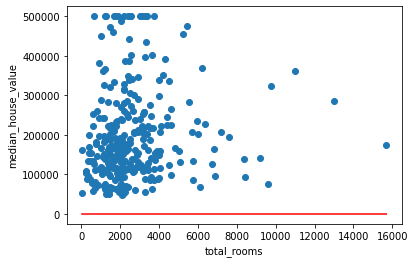

In [13]:
# Get the min and max total_rooms values.
x_0 = sample["total_rooms"].min()
x_1 = sample["total_rooms"].max()

# Retrieve the final weight and bias generated during training.
weight = linear_regressor.get_variable_value('linear/linear_model/total_rooms/weights')[0]
bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

# Get the predicted median_house_values for the min and max total_rooms values.
y_0 = weight * x_0 + bias 
y_1 = weight * x_1 + bias

# Plot our regression line from (x_0, y_0) to (x_1, y_1).
plt.plot([x_0, x_1], [y_0, y_1], c='r')

# Label the graph axes.
plt.ylabel("median_house_value")
plt.xlabel("total_rooms")

# Plot a scatter plot from our data sample.
plt.scatter(sample["total_rooms"], sample["median_house_value"])

# Display graph.
plt.show()

Diese anfängliche Zeile sieht weit entfernt aus. Unser Modell hat also nicht gut angenähert und vorhergesagt. Schauen wir mal, ob wir in den zusammenfassenden Statistiken dieselben Informationen finden können, die dort kodiert sind.

Zusammengenommen deuten diese ersten Überprüfungen darauf hin, dass wir in der Lage sein könnten, eine viel bessere Vorhersage zu finden, sprich: Das Modell ist noch nicht *konvergiert*.

## Ändere die Hyperparameter des Modells.
Für diese Übung haben wir den gesamten obigen Code der Einfachheit halber in einer einzigen Funktion zusammengefasst. Du kannst die Funktion mit verschiedenen Parametern aufrufen, um die Auswirkungen zu sehen.

In dieser Funktion werden wir in 10 gleichmäßig aufgeteilten Perioden vorgehen, so dass wir die Modellverbesserung in jeder Periode beobachten können.

Für jede Periode werden wir den Trainingsverlust berechnen und grafisch darstellen.  Dies kann dir helfen, zu beurteilen, wann ein Modell konvergiert ist oder ob es mehr Iterationen benötigt.

Wir werden auch die Werte für die Merkmalsgewichtung und den Bias-Term, die das Modell im Laufe der Zeit gelernt hat, grafisch darstellen.  Dies ist eine weitere Möglichkeit zu sehen, wie die Dinge konvergieren.

In [14]:
def train_model(learning_rate, steps, batch_size, input_feature="median_income"):
  """Trains a linear regression model of one feature.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `california_housing_dataframe`
      to use as input feature.
  """
  
  periods = 15
  steps_per_period = steps / periods

  my_feature = input_feature
  my_feature_data = california_housing_dataframe[[my_feature]]
  my_label = "median_house_value"
  targets = california_housing_dataframe[my_label]

  # Create feature columns.
  feature_columns = [tf.feature_column.numeric_column(my_feature)]
  
  # Create input functions.
  training_input_fn = lambda:my_input_fn(my_feature_data, targets, batch_size=batch_size)
  prediction_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
  
  # Use gradient descent as the optimizer for training the model.
  my_optimizer = partial(tf.keras.optimizers.legacy.SGD, learning_rate=learning_rate, clipnorm=5.0)

  # Configure the linear regression model with our feature columns and optimizer.
  # Set a learning rate of 0.0000001 for Gradient Descent.
  linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=feature_columns,
    optimizer=my_optimizer
  )

  # Set up to plot the state of our model's line each period.
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = california_housing_dataframe.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  root_mean_squared_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    _ = linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    predictions = linear_regressor.predict(input_fn=prediction_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    
    # Compute loss.
    root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(predictions, targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    root_mean_squared_errors.append(root_mean_squared_error)
    # Finally, track the weights and biases over time.
    # Apply some math to ensure that the data and line are plotted neatly.
    y_extents = np.array([0, sample[my_label].max()])
    
    weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
    bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

    x_extents = (y_extents - bias) / weight
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = weight * x_extents + bias
    plt.plot(x_extents, y_extents, color=colors[period]) 
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.subplot(1, 2, 2)
  plt.ylabel('RMSE')
  plt.xlabel('Periods')
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)

  # Output a table with calibration data.
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  display(calibration_data.describe())

  print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)

## Aufgabe 1:  Erziele einen RMSE von 180.000 oder weniger

Passe die Hyperparameter des Modells an, um den Verlust zu verbessern und besser mit der Zielverteilung übereinzustimmen.
Wenn du nach etwa 15 Minuten Schwierigkeiten hast, einen RMSE von 180 zu erreichen, prüfe die Lösung auf eine mögliche Kombination.

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpvizenn29', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Training model...
RMSE (on training data):
INFO:tensorflow:Calling model_fn.
INFO

/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpvizenn29/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 116385930000.0, step = 0
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 67...
INFO:tensorflow:Saving checkpoints for 67 into /tmp/tmpvizenn29/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 67...
INFO:tensorflow:Loss for final step: 26567852000.0.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpvizenn29/model.ckpt-67
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
  period 00 : 237539.69
INFO:tensorflow:Calling model_fn.
INFO:

/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpvizenn29/model.ckpt-67
Instructions for updating:
Use standard file utilities to get mtimes.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 67...
INFO:tensorflow:Saving checkpoints for 67 into /tmp/tmpvizenn29/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 67...
INFO:tensorflow:loss = 67081560000.0, step = 67
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 134...
INFO:tensorflow:Saving checkpoints for 134 into /tmp/tmpvizenn29/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 134...
INFO:tensorflow:Loss for final step: 69323145000.0.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpvizenn29/model.ckpt-

/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpvizenn29/model.ckpt-134
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 134...
INFO:tensorflow:Saving checkpoints for 134 into /tmp/tmpvizenn29/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 134...
INFO:tensorflow:loss = 14839868000.0, step = 134
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 201...
INFO:tensorflow:Saving checkpoints for 201 into /tmp/tmpvizenn29/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 201...
INFO:tensorflow:Loss for final step: 113250350000.0.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpvizenn29/model.ckpt-201
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done 

/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpvizenn29/model.ckpt-201
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 201...
INFO:tensorflow:Saving checkpoints for 201 into /tmp/tmpvizenn29/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 201...
INFO:tensorflow:loss = 77890730000.0, step = 201
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 268...
INFO:tensorflow:Saving checkpoints for 268 into /tmp/tmpvizenn29/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 268...
INFO:tensorflow:Loss for final step: 43205493000.0.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpvi

/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpvizenn29/model.ckpt-268
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 268...
INFO:tensorflow:Saving checkpoints for 268 into /tmp/tmpvizenn29/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 268...
INFO:tensorflow:loss = 34333512000.0, step = 268
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 335...
INFO:tensorflow:Saving checkpoints for 335 into /tmp/tmpvizenn29/model.ckpt.
Instructions for updating:
Use standard file APIs to delete files with this prefix.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 335...
INFO:tensorflow:Loss for final step: 28973701000.0.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpv

/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpvizenn29/model.ckpt-335
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 335...
INFO:tensorflow:Saving checkpoints for 335 into /tmp/tmpvizenn29/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 335...
INFO:tensorflow:loss = 86118450000.0, step = 335
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 402...
INFO:tensorflow:Saving checkpoints for 402 into /tmp/tmpvizenn29/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 402...
INFO:tensorflow:Loss for final step: 33827930000.0.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpvizenn29/model.ckpt-402
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done r

/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpvizenn29/model.ckpt-402
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 402...
INFO:tensorflow:Saving checkpoints for 402 into /tmp/tmpvizenn29/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 402...
INFO:tensorflow:loss = 44167750000.0, step = 402
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 469...
INFO:tensorflow:Saving checkpoints for 469 into /tmp/tmpvizenn29/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 469...
INFO:tensorflow:Loss for final step: 17767207000.0.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpvizenn29/model.ckpt-469
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done r

/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpvizenn29/model.ckpt-469
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 469...
INFO:tensorflow:Saving checkpoints for 469 into /tmp/tmpvizenn29/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 469...
INFO:tensorflow:loss = 39308780000.0, step = 469
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 536...
INFO:tensorflow:Saving checkpoints for 536 into /tmp/tmpvizenn29/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 536...
INFO:tensorflow:Loss for final step: 25907917000.0.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpvizenn29/model.ckpt-536
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done r

/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpvizenn29/model.ckpt-536
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 536...
INFO:tensorflow:Saving checkpoints for 536 into /tmp/tmpvizenn29/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 536...
INFO:tensorflow:loss = 31193300000.0, step = 536
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 603...
INFO:tensorflow:Saving checkpoints for 603 into /tmp/tmpvizenn29/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 603...
INFO:tensorflow:Loss for final step: 47094014000.0.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpvizenn29/model.ckpt-603
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done r

/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpvizenn29/model.ckpt-603
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 603...
INFO:tensorflow:Saving checkpoints for 603 into /tmp/tmpvizenn29/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 603...
INFO:tensorflow:loss = 42247330000.0, step = 603
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 670...
INFO:tensorflow:Saving checkpoints for 670 into /tmp/tmpvizenn29/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 670...
INFO:tensorflow:Loss for final step: 27546137000.0.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpvizenn29/model.ckpt-670
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done r

/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpvizenn29/model.ckpt-670
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 670...
INFO:tensorflow:Saving checkpoints for 670 into /tmp/tmpvizenn29/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 670...
INFO:tensorflow:loss = 16655477000.0, step = 670
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 737...
INFO:tensorflow:Saving checkpoints for 737 into /tmp/tmpvizenn29/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 737...
INFO:tensorflow:Loss for final step: 45563850000.0.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpvizenn29/model.ckpt-737
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done r

/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpvizenn29/model.ckpt-737
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 737...
INFO:tensorflow:Saving checkpoints for 737 into /tmp/tmpvizenn29/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 737...
INFO:tensorflow:loss = 83232800000.0, step = 737
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 804...
INFO:tensorflow:Saving checkpoints for 804 into /tmp/tmpvizenn29/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 804...
INFO:tensorflow:Loss for final step: 32483869000.0.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpvizenn29/model.ckpt-804
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done r

/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpvizenn29/model.ckpt-804
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 804...
INFO:tensorflow:Saving checkpoints for 804 into /tmp/tmpvizenn29/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 804...
INFO:tensorflow:loss = 103315340000.0, step = 804
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 871...
INFO:tensorflow:Saving checkpoints for 871 into /tmp/tmpvizenn29/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 871...
INFO:tensorflow:Loss for final step: 14157539000.0.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpvizenn29/model.ckpt-871
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done 

/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpvizenn29/model.ckpt-871
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 871...
INFO:tensorflow:Saving checkpoints for 871 into /tmp/tmpvizenn29/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 871...
INFO:tensorflow:loss = 56926155000.0, step = 871
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 938...
INFO:tensorflow:Saving checkpoints for 938 into /tmp/tmpvizenn29/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 938...
INFO:tensorflow:Loss for final step: 33332679000.0.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpvizenn29/model.ckpt-938
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done r

/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpvizenn29/model.ckpt-938
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 938...
INFO:tensorflow:Saving checkpoints for 938 into /tmp/tmpvizenn29/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 938...
INFO:tensorflow:loss = 55712047000.0, step = 938
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1005...
INFO:tensorflow:Saving checkpoints for 1005 into /tmp/tmpvizenn29/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1005...
INFO:tensorflow:Loss for final step: 28235094000.0.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpvizenn29/model.ckpt-1005
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Do

,predictions,targets
count,17000.0,17000.0
mean,0.2,207300.9
std,0.1,115983.8
min,0.1,14999.0
25%,0.2,119400.0
50%,0.2,180400.0
75%,0.3,265000.0
max,0.8,500001.0


Final RMSE (on training data): 237539.46


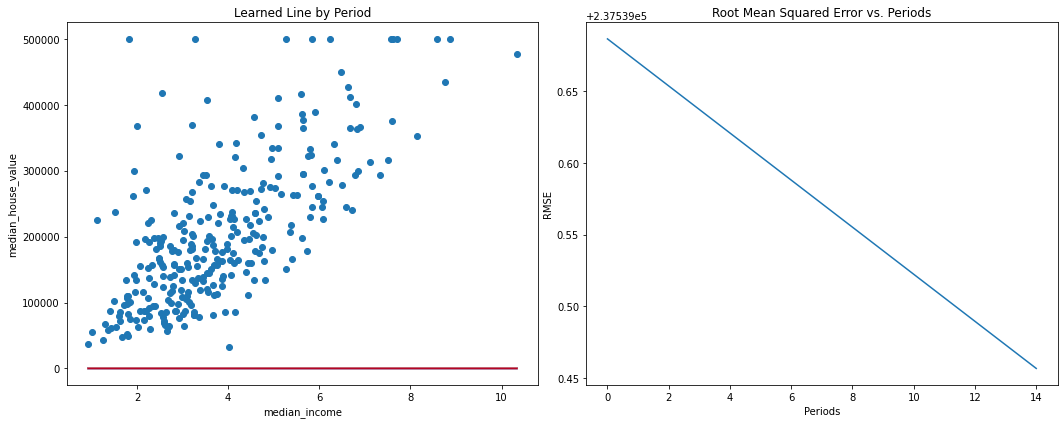

In [ ]:
train_model(
    learning_rate=0.00001,
    steps=1000,
    batch_size=10
)

### Lösung

Schau hier für eine mögliche Lösung.

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmphard114u', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Training model...
RMSE (on training data):
INFO:tensorflow:Calling model_fn.
INFO

/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmphard114u/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 53461820000.0, step = 0
INFO:tensorflow:global_step/sec: 377.527
INFO:tensorflow:loss = 60588745000.0, step = 100 (0.270 sec)
INFO:tensorflow:global_step/sec: 445.112
INFO:tensorflow:loss = 75463885000.0, step = 200 (0.225 sec)
INFO:tensorflow:global_step/sec: 412.996
INFO:tensorflow:loss = 52373800000.0, step = 300 (0.242 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 334...
INFO:tensorflow:Saving checkpoints for 334 into /tmp/tmphard114u/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 334...
INFO:tensorflow:Loss for final step: 52690985000.0.
INFO:tensorflow:Calli

/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmphard114u/model.ckpt-334
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 334...
INFO:tensorflow:Saving checkpoints for 334 into /tmp/tmphard114u/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 334...
INFO:tensorflow:loss = 36451275000.0, step = 334
INFO:tensorflow:global_step/sec: 353.993
INFO:tensorflow:loss = 110247800000.0, step = 434 (0.288 sec)
INFO:tensorflow:global_step/sec: 428.033
INFO:tensorflow:loss = 76744300000.0, step = 534 (0.234 sec)
INFO:tensorflow:global_step/sec: 412.425
INFO:tensorflow:loss = 43744120000.0, step = 634 (0.242 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 668...
INFO:tensorflow:Saving checkpoints for 668 into /tmp/tmphard114u/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoi

/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmphard114u/model.ckpt-668
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 668...
INFO:tensorflow:Saving checkpoints for 668 into /tmp/tmphard114u/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 668...
INFO:tensorflow:loss = 44817986000.0, step = 668
INFO:tensorflow:global_step/sec: 359.954
INFO:tensorflow:loss = 44699087000.0, step = 768 (0.280 sec)
INFO:tensorflow:global_step/sec: 425.081
INFO:tensorflow:loss = 13761594000.0, step = 868 (0.238 sec)
INFO:tensorflow:global_step/sec: 418.941
INFO:tensorflow:loss = 33418406000.0, step = 968 (0.239 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1002...
INFO:tensorflow:Saving checkpoints for 1002 into /tmp/tmphard114u/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpo

/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmphard114u/model.ckpt-1002
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1002...
INFO:tensorflow:Saving checkpoints for 1002 into /tmp/tmphard114u/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1002...
INFO:tensorflow:loss = 33608086000.0, step = 1002
INFO:tensorflow:global_step/sec: 344.945
INFO:tensorflow:loss = 49041764000.0, step = 1102 (0.295 sec)
INFO:tensorflow:global_step/sec: 408.754
INFO:tensorflow:loss = 140879330000.0, step = 1202 (0.244 sec)
INFO:tensorflow:global_step/sec: 411.505
INFO:tensorflow:loss = 34718466000.0, step = 1302 (0.244 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1336...
INFO:tensorflow:Saving checkpoints for 1336 into /tmp/tmphard114u/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after savin

/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmphard114u/model.ckpt-1336
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1336...
INFO:tensorflow:Saving checkpoints for 1336 into /tmp/tmphard114u/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1336...
INFO:tensorflow:loss = 76531130000.0, step = 1336
INFO:tensorflow:global_step/sec: 350.448
INFO:tensorflow:loss = 65017860000.0, step = 1436 (0.290 sec)
INFO:tensorflow:global_step/sec: 446.727
INFO:tensorflow:loss = 42974695000.0, step = 1536 (0.223 sec)
INFO:tensorflow:global_step/sec: 446.855
INFO:tensorflow:loss = 67368497000.0, step = 1636 (0.224 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1670...
INFO:tensorflow:Saving checkpoints for 1670 into /tm

/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmphard114u/model.ckpt-1670
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1670...
INFO:tensorflow:Saving checkpoints for 1670 into /tmp/tmphard114u/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1670...
INFO:tensorflow:loss = 86582624000.0, step = 1670
INFO:tensorflow:global_step/sec: 350.181
INFO:tensorflow:loss = 28298013000.0, step = 1770 (0.291 sec)
INFO:tensorflow:global_step/sec: 403.644
INFO:tensorflow:loss = 7655436300.0, step = 1870 (0.247 sec)
INFO:tensorflow:global_step/sec: 428.262
INFO:tensorflow:loss = 23635878000.0, step = 1970 (0.234 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 2004...
INFO:tensorflow:Saving checkpoints for 2004 into /tmp/tmphard114u/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving 

/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmphard114u/model.ckpt-2004
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 2004...
INFO:tensorflow:Saving checkpoints for 2004 into /tmp/tmphard114u/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 2004...
INFO:tensorflow:loss = 83564260000.0, step = 2004
INFO:tensorflow:global_step/sec: 359.346
INFO:tensorflow:loss = 47427183000.0, step = 2104 (0.285 sec)
INFO:tensorflow:global_step/sec: 428.848
INFO:tensorflow:loss = 52693484000.0, step = 2204 (0.232 sec)
INFO:tensorflow:global_step/sec: 415.757
INFO:tensorflow:loss = 5207022000.0, step = 2304 (0.240 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 2338...
INFO:tensorflow:Saving checkpoints for 2338 into /tmp/tmphard114u/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving 

/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmphard114u/model.ckpt-2338
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 2338...
INFO:tensorflow:Saving checkpoints for 2338 into /tmp/tmphard114u/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 2338...
INFO:tensorflow:loss = 88878230000.0, step = 2338
INFO:tensorflow:global_step/sec: 351.01
INFO:tensorflow:loss = 73585210000.0, step = 2438 (0.290 sec)
INFO:tensorflow:global_step/sec: 431.086
INFO:tensorflow:loss = 81451060000.0, step = 2538 (0.232 sec)
INFO:tensorflow:global_step/sec: 396.46
INFO:tensorflow:loss = 25328167000.0, step = 2638 (0.252 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 2672...
INFO:tensorflow:Saving checkpoints for 2672 into /tmp/tmphard114u/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving c

/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmphard114u/model.ckpt-2672
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 2672...
INFO:tensorflow:Saving checkpoints for 2672 into /tmp/tmphard114u/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 2672...
INFO:tensorflow:loss = 71751760000.0, step = 2672
INFO:tensorflow:global_step/sec: 362.531
INFO:tensorflow:loss = 43137167000.0, step = 2772 (0.281 sec)
INFO:tensorflow:global_step/sec: 416.623
INFO:tensorflow:loss = 66746135000.0, step = 2872 (0.240 sec)
INFO:tensorflow:global_step/sec: 406.252
INFO:tensorflow:loss = 71290950000.0, step = 2972 (0.246 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 3006...
INFO:tensorflow:Saving checkpoints for 3006 into /tmp/tmphard114u/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving

/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmphard114u/model.ckpt-3006
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 3006...
INFO:tensorflow:Saving checkpoints for 3006 into /tmp/tmphard114u/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 3006...
INFO:tensorflow:loss = 54282460000.0, step = 3006
INFO:tensorflow:global_step/sec: 344.268
INFO:tensorflow:loss = 33387100000.0, step = 3106 (0.297 sec)
INFO:tensorflow:global_step/sec: 418.354
INFO:tensorflow:loss = 38911713000.0, step = 3206 (0.239 sec)
INFO:tensorflow:global_step/sec: 409.744
INFO:tensorflow:loss = 69224920000.0, step = 3306 (0.244 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 3340...
INFO:tensorflow:Saving checkpoints for 3340 into /tmp/tmphard114u/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving

/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmphard114u/model.ckpt-3340
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 3340...
INFO:tensorflow:Saving checkpoints for 3340 into /tmp/tmphard114u/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 3340...
INFO:tensorflow:loss = 41697456000.0, step = 3340
INFO:tensorflow:global_step/sec: 352.344
INFO:tensorflow:loss = 102157705000.0, step = 3440 (0.289 sec)
INFO:tensorflow:global_step/sec: 445.648
INFO:tensorflow:loss = 70473196000.0, step = 3540 (0.224 sec)
INFO:tensorflow:global_step/sec: 442.125
INFO:tensorflow:loss = 75401180000.0, step = 3640 (0.227 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 3674...
INFO:tensorflow:Saving checkpoints for 3674 into /tmp/tmphard114u/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after savin

/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmphard114u/model.ckpt-3674
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 3674...
INFO:tensorflow:Saving checkpoints for 3674 into /tmp/tmphard114u/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 3674...
INFO:tensorflow:loss = 25960507000.0, step = 3674
INFO:tensorflow:global_step/sec: 366.55
INFO:tensorflow:loss = 46591545000.0, step = 3774 (0.278 sec)
INFO:tensorflow:global_step/sec: 426.341
INFO:tensorflow:loss = 44620116000.0, step = 3874 (0.235 sec)
INFO:tensorflow:global_step/sec: 410.713
INFO:tensorflow:loss = 14974411000.0, step = 3974 (0.243 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 4008...
INFO:tensorflow:Saving checkpoints for 4008 into /tmp/tmphard114u/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving 

/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmphard114u/model.ckpt-4008
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 4008...
INFO:tensorflow:Saving checkpoints for 4008 into /tmp/tmphard114u/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 4008...
INFO:tensorflow:loss = 51861668000.0, step = 4008
INFO:tensorflow:global_step/sec: 343.589
INFO:tensorflow:loss = 115682450000.0, step = 4108 (0.296 sec)
INFO:tensorflow:global_step/sec: 433.002
INFO:tensorflow:loss = 130656340000.0, step = 4208 (0.231 sec)
INFO:tensorflow:global_step/sec: 424.663
INFO:tensorflow:loss = 16977133000.0, step = 4308 (0.238 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 4342...
INFO:tensorflow:Saving checkpoints for 4342 into /tmp/tmphard114u/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after savi

/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmphard114u/model.ckpt-4342
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 4342...
INFO:tensorflow:Saving checkpoints for 4342 into /tmp/tmphard114u/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 4342...
INFO:tensorflow:loss = 31139330000.0, step = 4342
INFO:tensorflow:global_step/sec: 353.567
INFO:tensorflow:loss = 81504080000.0, step = 4442 (0.288 sec)
INFO:tensorflow:global_step/sec: 444.244
INFO:tensorflow:loss = 45472805000.0, step = 4542 (0.225 sec)
INFO:tensorflow:global_step/sec: 432.791
INFO:tensorflow:loss = 53696156000.0, step = 4642 (0.232 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 4676...
INFO:tensorflow:Saving checkpoints for 4676 into /tmp/tmphard114u/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving

/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmphard114u/model.ckpt-4676
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 4676...
INFO:tensorflow:Saving checkpoints for 4676 into /tmp/tmphard114u/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 4676...
INFO:tensorflow:loss = 119068920000.0, step = 4676
INFO:tensorflow:global_step/sec: 365.143
INFO:tensorflow:loss = 83726720000.0, step = 4776 (0.279 sec)
INFO:tensorflow:global_step/sec: 435.139
INFO:tensorflow:loss = 73061130000.0, step = 4876 (0.229 sec)
INFO:tensorflow:global_step/sec: 435.917
INFO:tensorflow:loss = 25954877000.0, step = 4976 (0.229 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 5010...
INFO:tensorflow:Saving checkpoints for 5010 into /tmp/tmphard114u/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after savin

,predictions,targets
count,17000.0,17000.0
mean,12233.4,207300.9
std,4779.9,115983.8
min,3757.2,14999.0
25%,8933.8,119400.0
50%,11384.2,180400.0
75%,14446.3,265000.0
max,40080.2,500001.0


Final RMSE (on training data): 225296.57


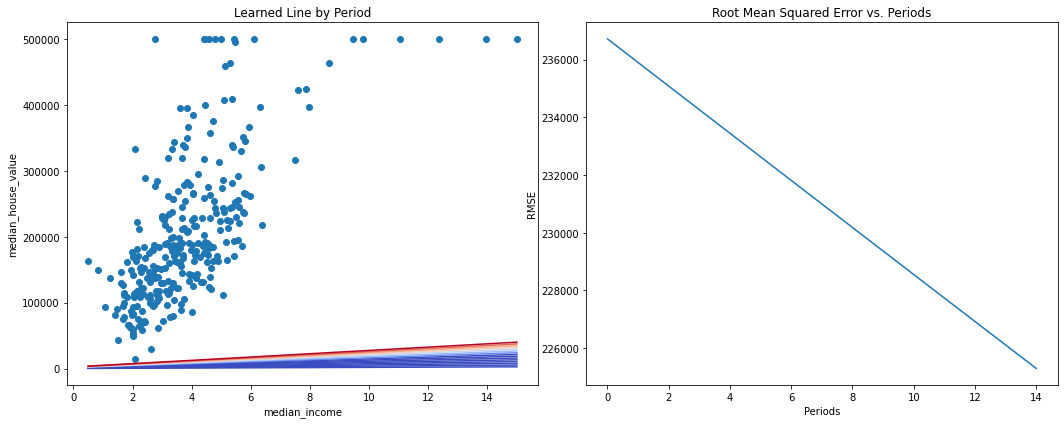

In [ ]:
#@title Lösung
train_model(
    learning_rate=0.75,
    steps=7000,
    batch_size=100
)

Dies ist nur eine mögliche Konfiguration; es kann andere Kombinationen von Einstellungen geben, die ebenfalls gute Ergebnisse liefern. Beachte, dass es bei dieser Übung im Allgemeinen nicht darum geht, die *eine beste* Einstellung zu finden, sondern darum, deine Vorstellungen darüber zu entwickeln, wie sich das Optimieren der Modellkonfiguration auf die Vorhersagequalität auswirkt.

### Gibt es eine Standard-Heuristik für die Modellabstimmung?

Dies ist eine häufig gestellte Frage. Die kurze Antwort ist, dass die Auswirkungen der verschiedenen Hyperparameter datenabhängig sind. Es gibt also keine festen Regeln; Du musst mit deinen Daten testen.

Dennoch gibt es ein paar Faustregeln, die Ihnen als Orientierung dienen können:

 * Der Trainingsfehler sollte stetig abnehmen, anfangs steil, und sollten schließlich ein Plateau erreichen, wenn das Training konvergiert.
 * Wenn das Training nicht konvergiert, versuche, es länger laufen zu lassen.
 * Wenn der Trainingsfehler zu langsam abnimmt, kann eine Erhöhung der Lernrate dazu beitragen, dass er schneller abnimmt.
   * Manchmal kann aber auch genau das Gegenteil passieren, wenn die Lernrate zu hoch ist.
 * Wenn der Trainingsfehler sehr stark schwankt, versuchen Sie, die Lernrate zu verringern.
   * Eine niedrigere Lernrate plus eine größere Anzahl von Schritten oder eine größere Batchgröße ist oft eine gute Kombination.
 * Sehr kleine Batchgrößen können ebenfalls Instabilität verursachen.  Versuchen Sie zunächst größere Werte wie 100 oder 1000 und verringern Sie diese, bis Sie eine Verschlechterung feststellen.

Auch hier gilt: Halte dich nie strikt an diese Faustregeln, da die Auswirkungen datenabhängig sind.  Experimentiere immer und verifizieren dann deine Ergebnisse.

## Aufgabe 2: Versuche ein anderes Feature

Schauen Sie, ob du besser machen kannst, indem du das Feature "Total_rooms" durch das Feature "Population" ersetzst.

Nimm dir für diesen Teil nicht mehr als 15 Minuten Zeit.

In [ ]:
# YOUR CODE HERE

Lösung:


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp05t_yu_6', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Training model...
RMSE (on training data):
INFO:tensorflow:Calling model_fn.
INFO

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp05t_yu_6/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 93877220000.0, step = 0
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 67...
INFO:tensorflow:Saving checkpoints for 67 into /tmp/tmp05t_yu_6/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 67...
INFO:tensorflow:Loss for final step: 61161165000.0.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp05t_yu_6/model.ckpt-67
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
  period 00 : 237531.44
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 67...
INFO:tensorflow:Saving checkpoints for 67 into /tmp/tmp05t_yu_6/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 67...
INFO:tensorflow:loss = 32417343000.0, step = 67
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 134...
INFO:tensorflow:Saving checkpoints for 134 into /tmp/tmp05t_yu_6/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 134...
INFO:tensorflow:Loss for final step: 203148700000.0.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp05t_yu_6/model.ckpt-134
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
  period 01 : 237523.18
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalize

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 134...
INFO:tensorflow:Saving checkpoints for 134 into /tmp/tmp05t_yu_6/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 134...
INFO:tensorflow:loss = 13081085000.0, step = 134
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 201...
INFO:tensorflow:Saving checkpoints for 201 into /tmp/tmp05t_yu_6/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 201...
INFO:tensorflow:Loss for final step: 12835465000.0.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp05t_yu_6/model.ckpt-201
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
  period 02 : 237514.92
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was final

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 201...
INFO:tensorflow:Saving checkpoints for 201 into /tmp/tmp05t_yu_6/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 201...
INFO:tensorflow:loss = 42190623000.0, step = 201
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 268...
INFO:tensorflow:Saving checkpoints for 268 into /tmp/tmp05t_yu_6/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 268...
INFO:tensorflow:Loss for final step: 8845520000.0.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp05t_yu_6/model.ckpt-268
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
  period 03 : 237506.67
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finali

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 268...
INFO:tensorflow:Saving checkpoints for 268 into /tmp/tmp05t_yu_6/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 268...
INFO:tensorflow:loss = 49015640000.0, step = 268
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 335...
INFO:tensorflow:Saving checkpoints for 335 into /tmp/tmp05t_yu_6/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 335...
INFO:tensorflow:Loss for final step: 3663178200.0.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp05t_yu_6/model.ckpt-335
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
  period 04 : 237498.41
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling mod

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 335...
INFO:tensorflow:Saving checkpoints for 335 into /tmp/tmp05t_yu_6/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 335...
INFO:tensorflow:loss = 40519150000.0, step = 335
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 402...
INFO:tensorflow:Saving checkpoints for 402 into /tmp/tmp05t_yu_6/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 402...
INFO:tensorflow:Loss for final step: 164952360000.0.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp05t_yu_6/model.ckpt-402
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
  period 05 : 237490.15
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was fina

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 402...
INFO:tensorflow:Saving checkpoints for 402 into /tmp/tmp05t_yu_6/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 402...
INFO:tensorflow:loss = 52275417000.0, step = 402
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 469...
INFO:tensorflow:Saving checkpoints for 469 into /tmp/tmp05t_yu_6/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 469...
INFO:tensorflow:Loss for final step: 7000876500.0.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp05t_yu_6/model.ckpt-469
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
  period 06 : 237481.89
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create Checkpoin

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 469...
INFO:tensorflow:Saving checkpoints for 469 into /tmp/tmp05t_yu_6/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 469...
INFO:tensorflow:loss = 160836830000.0, step = 469
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 536...
INFO:tensorflow:Saving checkpoints for 536 into /tmp/tmp05t_yu_6/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 536...
INFO:tensorflow:Loss for final step: 91574170000.0.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp05t_yu_6/model.ckpt-536
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
  period 07 : 237473.63
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was fina

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 536...
INFO:tensorflow:Saving checkpoints for 536 into /tmp/tmp05t_yu_6/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 536...
INFO:tensorflow:loss = 14172035000.0, step = 536
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 603...
INFO:tensorflow:Saving checkpoints for 603 into /tmp/tmp05t_yu_6/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 603...
INFO:tensorflow:Loss for final step: 50586026000.0.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp05t_yu_6/model.ckpt-603
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
  period 08 : 237465.38
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling mo

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 603...
INFO:tensorflow:Saving checkpoints for 603 into /tmp/tmp05t_yu_6/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 603...
INFO:tensorflow:loss = 27473586000.0, step = 603
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 670...
INFO:tensorflow:Saving checkpoints for 670 into /tmp/tmp05t_yu_6/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 670...
INFO:tensorflow:Loss for final step: 14074441000.0.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp05t_yu_6/model.ckpt-670
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
  period 09 : 237457.12
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was final

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 670...
INFO:tensorflow:Saving checkpoints for 670 into /tmp/tmp05t_yu_6/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 670...
INFO:tensorflow:loss = 27650101000.0, step = 670
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 737...
INFO:tensorflow:Saving checkpoints for 737 into /tmp/tmp05t_yu_6/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 737...
INFO:tensorflow:Loss for final step: 52151775000.0.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp05t_yu_6/model.ckpt-737
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
  period 10 : 237448.86
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was final

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 737...
INFO:tensorflow:Saving checkpoints for 737 into /tmp/tmp05t_yu_6/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 737...
INFO:tensorflow:loss = 45988440000.0, step = 737
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 804...
INFO:tensorflow:Saving checkpoints for 804 into /tmp/tmp05t_yu_6/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 804...
INFO:tensorflow:Loss for final step: 117550700000.0.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp05t_yu_6/model.ckpt-804
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
  period 11 : 237440.61
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was fina

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 804...
INFO:tensorflow:Saving checkpoints for 804 into /tmp/tmp05t_yu_6/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 804...
INFO:tensorflow:loss = 83588140000.0, step = 804
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 871...
INFO:tensorflow:Saving checkpoints for 871 into /tmp/tmp05t_yu_6/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 871...
INFO:tensorflow:Loss for final step: 26077198000.0.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp05t_yu_6/model.ckpt-871
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
  period 12 : 237432.35
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was final

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 871...
INFO:tensorflow:Saving checkpoints for 871 into /tmp/tmp05t_yu_6/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 871...
INFO:tensorflow:loss = 18772896000.0, step = 871
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 938...
INFO:tensorflow:Saving checkpoints for 938 into /tmp/tmp05t_yu_6/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 938...
INFO:tensorflow:Loss for final step: 71123170000.0.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp05t_yu_6/model.ckpt-938
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
  period 13 : 237424.09
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was final

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 938...
INFO:tensorflow:Saving checkpoints for 938 into /tmp/tmp05t_yu_6/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 938...
INFO:tensorflow:loss = 10455576000.0, step = 938
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1005...
INFO:tensorflow:Saving checkpoints for 1005 into /tmp/tmp05t_yu_6/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1005...
INFO:tensorflow:Loss for final step: 153476800000.0.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp05t_yu_6/model.ckpt-1005
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
  period 14 : 237415.84
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,143.8,207300.9
std,115.4,115983.8
min,0.4,14999.0
25%,79.5,119400.0
50%,117.4,180400.0
75%,173.1,265000.0
max,3586.2,500001.0


Final RMSE (on training data): 237415.84


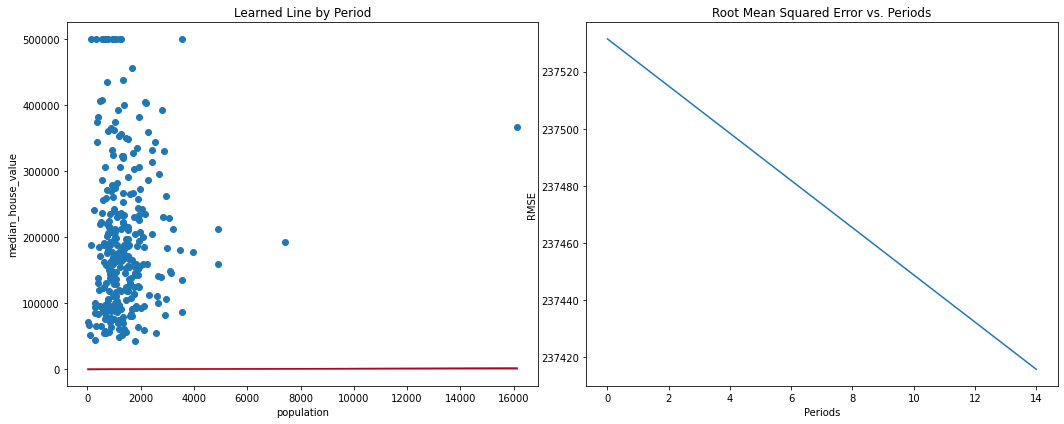

In [ ]:
#@title Lösung
train_model(
    learning_rate=0.00002,
    steps=1000,
    batch_size=5,
    input_feature="population"
)